In [166]:
# Standard library imports
import os
from datetime import datetime, date
from pathlib import Path
from typing import Dict, Tuple, Any, Optional, List, Literal, Union, Callable
from dotenv import load_dotenv
import warnings

# Silence all warnings since I reviewed them
warnings.filterwarnings('ignore')

# Data processing imports
import numpy as np
import pandas as pd
from sqlalchemy import create_engine, inspect

# Data visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Financial data imports
import yfinance as yf

# Machine learning imports
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

plt.style.use('ggplot')
sns.set_style('whitegrid')

### Step 1: Read, Clean, and Process Input Data

In [167]:
def get_database_credentials() -> Dict[str, str]:
    """
    Get database credentials from environment variables.
    
    Returns:
    -------
    Dict[str, str]: Database connection parameters
    """
    # Load environment variables from .env file if it exists
    load_dotenv()
    
    # Get credentials with fallbacks to default values
    return {
        "user": os.environ.get("DB_USER"),
        "password": os.environ.get("DB_PASSWORD"),
        "host": os.environ.get("DB_HOST"),
        "database": os.environ.get("DB_NAME")
    }

In [168]:
def create_connection() -> Any:
    """
    Create and return a database connection engine.
    
    Returns:
    -------
    sqlalchemy.engine.Engine: SQLAlchemy database engine
    """
    creds = get_database_credentials()
    
    # Create connection string
    conn_str = (
        "mysql+pymysql://{user}:{password}@{host}/{database}"
    ).format(**creds)
    
    # Build engine
    return create_engine(conn_str)

In [169]:
def load_universe_data(engine: Any) -> pd.DataFrame:
    """
    Load and analyze universe data.
    
    Parameters:
    ----------
    engine: sqlalchemy.engine.Engine
        Database connection engine
    
    Returns:
    -------
    pd.DataFrame: DataFrame containing universe data
    """
    # Load universe data
    universe_df = pd.read_sql("SELECT * FROM vf_universe;", engine)
    print(f"Universe shape: {universe_df.shape}")
    
    # Analyze universe data
    print(f"Unique exchanges: {universe_df['exchange'].unique()}")
    print(f"Unique categories: {universe_df['category'].unique()}")
    print(f"Unique table codes: {universe_df.groupby(['table_code'])['ticker'].nunique()}")
    print(f"Unique scalemarketcap: {universe_df['scalemarketcap'].unique()}")
    
    return universe_df

In [170]:
def load_metadata(engine: Any) -> pd.DataFrame:
    """
    Load and analyze metadata.
    
    Parameters:
    ----------
    engine: sqlalchemy.engine.Engine
        Database connection engine
    
    Returns:
    -------
    pd.DataFrame: DataFrame containing metadata
    """
    # Load metadata
    metadata_df = pd.read_sql("SELECT * FROM vf_metadata;", engine)
    print(f"Metadata shape: {metadata_df.shape}")
    
    # Analyze metadata
    print(f"Unique table codes: {metadata_df['table_code'].unique()}")
    print(metadata_df[metadata_df['table_code'] == 'SF1'][['title', 'description']].drop_duplicates())
    print(metadata_df[metadata_df['table_code'] == 'SEP'][['title', 'description']].drop_duplicates())
    print(f"Unique titles: {metadata_df[metadata_df['table_code'] == 'SEP']['title'].unique()}")
    print(f"Unique titles: {sorted(metadata_df[metadata_df['table_code'] == 'SF1']['title'].unique())}")
    
    return metadata_df

In [171]:
def load_fundamentals(engine: Any) -> pd.DataFrame:
    """
    Load financial fundamentals data.
    
    Parameters:
    ----------
    engine: sqlalchemy.engine.Engine
        Database connection engine
    
    Returns:
    -------
    pd.DataFrame: DataFrame with fundamental data
    """
    # I am choosing TTM with restatements (MRT) since it smooths out seasonal swings and covers the most recent twelve months, 
    # giving a more stable and timely view than raw quarterly or annual snapshots. Including restatements ensures I'm using the corrected,
    #  most accurate historical figures. Excluding restatements risks relying on numbers later proven wrong. 
    # Applying an appropriate reporting lag to MRT balances signal freshness with look-ahead bias control.
    fundamentals_df = pd.read_sql(
        "SELECT * FROM case_study_2.vf_acct_sf1 WHERE dimension='MRT' AND ticker IS NOT NULL;", 
        engine
    )
    
    print(f"Number of unique tickers: {fundamentals_df['ticker'].nunique()}")
    print(f"Min and max datekey: {fundamentals_df['datekey'].min()}, {fundamentals_df['datekey'].max()}")
    print(f"Fundamentals shape: {fundamentals_df.shape}")
    
    return fundamentals_df

In [172]:
def load_borrow_fees(engine: Any) -> pd.DataFrame:
    """
    Load borrow fees data for relevant tickers.
    
    Parameters:
    ----------
    engine: sqlalchemy.engine.Engine
        Database connection engine
    
    Returns:
    -------
    pd.DataFrame: DataFrame with borrow fees
    """
    borrow_fees_df = pd.read_sql(
        """
        SELECT * FROM vf_borrow 
        WHERE `#SYM` IN (
            SELECT DISTINCT ticker 
            FROM case_study_2.vf_acct_sf1 
            WHERE ticker IS NOT NULL
        );
        """, 
        engine
    )
    
    return borrow_fees_df

In [173]:
def load_prices(engine: Any) -> pd.DataFrame:
    """
    Load historical price data for relevant tickers.
    
    Parameters:
    ----------
    engine: sqlalchemy.engine.Engine
        Database connection engine
    
    Returns:
    -------
    pd.DataFrame: DataFrame with price data
    """
    prices_df = pd.read_sql(
        """
        SELECT DISTINCT ticker, date, close, volume 
        FROM vf_marketdata_sep 
        WHERE ticker IN (
            SELECT DISTINCT ticker 
            FROM case_study_2.vf_acct_sf1 
            WHERE ticker IS NOT NULL
        ) 
        ORDER BY ticker, date;
        """, 
        engine
    )
    
    print(f"Prices shape: {prices_df.shape}")
    
    return prices_df

In [174]:
def load_all_data() -> Dict[str, Any]:
    """
    Load all datasets needed for analysis.
    
    Returns:
    -------
    Dict[str, Any]: Dictionary containing all loaded datasets
    """
    # Create database connection
    engine = create_connection()
    
    # Load all datasets
    data = {
        "engine": engine,
        "universe": load_universe_data(engine),
        "metadata": load_metadata(engine),
        "fundamentals": load_fundamentals(engine),
        "borrow_fees": load_borrow_fees(engine),
        "prices": load_prices(engine)
    }
    
    return data

In [175]:
def save_data_to_csv(data: Dict[str, Any], output_dir: Optional[str] = None) -> None:
    """
    Save loaded datasets to CSV files.
    
    Parameters:
    ----------
    data: Dict[str, Any]
        Dictionary containing datasets as returned by load_all_data()
    output_dir: Optional[str]
        Directory to save CSV files (defaults to current directory)
    
    Returns:
    -------
    None
    """
    dir_path = output_dir or '.'
    os.makedirs(dir_path, exist_ok=True)
    
    # Save each dataset to CSV
    data["universe"].to_csv(f"{dir_path}/universe.csv", index=False)
    data["metadata"].to_csv(f"{dir_path}/metadata.csv", index=False)
    data["fundamentals"].to_csv(f"{dir_path}/fundamentals.csv", index=False)
    data["borrow_fees"].to_csv(f"{dir_path}/borrow_fees.csv", index=False)
    data["prices"].to_csv(f"{dir_path}/prices.csv", index=False)
    
    print(f"All datasets saved to {dir_path}/")

In [176]:
def calculate_adv(
    prices_df: pd.DataFrame, 
    window: int = 60, 
    min_periods: int = 20
) -> pd.DataFrame:
    """
    Calculate Average Daily Volume (ADV) for each ticker.
    
    Parameters:
    ----------
    prices_df: pd.DataFrame
        Price data with ticker, date, volume columns
    window: int, default=60
        Rolling window size in days
    min_periods: int, default=20
        Minimum number of observations required
    
    Returns:
    -------
    pd.DataFrame: DataFrame with ADV_60d column added
    """
    df = prices_df.copy()
    
    # Sort by ticker and date
    df = df.sort_values(["ticker", "date"])
    
    # Calculate rolling average volume
    df["ADV_60d"] = (
        df.groupby("ticker")["volume"]
        .transform(lambda x: x.rolling(window=window, min_periods=min_periods).mean())
    )
    
    return df

In [177]:
def prepare_fundamentals(
    fundamentals_df: pd.DataFrame,
    lag_days: int = 60
) -> pd.DataFrame:
    """
    Prepare fundamentals data by adding availability dates.
    
    Parameters:
    ----------
    fundamentals_df: pd.DataFrame
        Fundamentals data
    lag_days: int, default=60
        Number of days to lag availability from datekey
    
    Returns:
    -------
    pd.DataFrame: Prepared fundamentals DataFrame
    """
    df = fundamentals_df.copy()
    
    # Sort by ticker and datekey
    # I use the datekey, since it represents the actual SEC‐filing or observation date
    # ensuring I'm only ever using information that was available at rebalance time. 
    # which avoids look-ahead bias and keeps my factor signals properly synchronized with market prices.
    df = df.sort_values(by=['ticker', 'datekey'])
    df['available_date'] = pd.to_datetime(df['datekey']) + pd.Timedelta(days=lag_days)
    df['available_date'] = pd.to_datetime(df['available_date'])
    
    return df

In [178]:
def fill_borrow_fees(borrow_fees_df: pd.DataFrame) -> pd.DataFrame:
    """
    Fill missing borrow fees data using business day reindexing.
    
    Parameters:
    ----------
    borrow_fees_df: pd.DataFrame
        Borrow fees data with date and #SYM columns
    
    Returns:
    -------
    pd.DataFrame: Filled borrow fees DataFrame
    """
    # Ensure datetime
    df = borrow_fees_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['#SYM','date']).drop_duplicates(['#SYM','date'], keep='last')

    filled = []
    for sym, grp in df.groupby('#SYM'):
        # Define that ticker's own business‐day range
        dr = pd.bdate_range(start=grp['date'].min(), end=grp['date'].max())

        # reindex and ffill within that window
        tmp = (
            grp
              .set_index('date')
              .reindex(dr)     # only days where this symbol existed
              .ffill()         # forward-fill fees & availability
        )
        tmp['#SYM'] = sym   # put symbol back
        filled.append(tmp.reset_index().rename(columns={'index':'date'}))

    filled_df = pd.concat(filled, ignore_index=True)
    
    # Calculate borrow cost
    filled_df['borrow_cost'] = filled_df.apply(
        lambda row: row['avg_fee_rate'] - max(row['avg_rebate_rate'], 0), 
        axis=1
    )
    
    return filled_df

In [179]:
def merge_fundamentals_with_prices(
    prices_df: pd.DataFrame, 
    fundamentals_df: pd.DataFrame,
    cols_to_include: Optional[List[str]] = None
) -> pd.DataFrame:
    """
    Merge fundamentals with prices using as-of merge.
    
    Parameters:
    ----------
    prices_df: pd.DataFrame
        Price data with date column as datetime
    fundamentals_df: pd.DataFrame
        Fundamentals data with available_date column as datetime
    cols_to_include: Optional[List[str]]
        List of columns to include from fundamentals
    
    Returns:
    -------
    pd.DataFrame: Merged DataFrame
    """
    # Ensure dates are datetime
    prices = prices_df.copy()
    funds = fundamentals_df.copy()
    
    prices['date'] = pd.to_datetime(prices['date'])
    
    # Default columns to include if none specified
    if cols_to_include is None:
        cols_to_include = ['ticker', 'available_date', 'marketcap', 
                          'roic', 'roa', 'roe', 'currentratio', 'grossmargin', 'de',
                          'pe1', 'pb', 'evebitda', 'divyield', 'fcfps']
    else:
        # Ensure required columns are included
        for col in ['ticker', 'available_date']:
            if col not in cols_to_include:
                cols_to_include.append(col)
    
    # Sort for merge_asof
    prices = prices.sort_values(['date'])
    funds = funds.sort_values(['available_date'])[cols_to_include]

    # Merge using merge_asof
    merged = pd.merge_asof(
        prices,
        funds,
        left_on='date',
        right_on='available_date',
        by='ticker',
        direction='backward'  # "last available fundamentals on or before each price date"
    )
    
    return merged.dropna(subset=['available_date'])

In [180]:
def add_forward_returns(
    df: pd.DataFrame, 
    period: int = 20,
    price_col: str = 'close'
) -> pd.DataFrame:
    """
    Add forward return calculations to a DataFrame.
    
    Parameters:
    ----------
    df: pd.DataFrame
        DataFrame with ticker, date and price data
    period: int, default=20
        Number of days forward for return calculation
    price_col: str, default='close'
        Column name for price data
    
    Returns:
    -------
    pd.DataFrame: DataFrame with forward returns added
    """
    result = df.copy()
    
    # Ensure sorted
    result = result.sort_values(['ticker', 'date'])
    
    # Calculate 1-month forward return
    result['return_1m_forward'] = result.groupby('ticker')[price_col] \
        .transform(lambda x: x.shift(-period) / x - 1)
    
    return result

In [181]:
def apply_filters(
    df: pd.DataFrame,
    min_market_cap: float = 1e9,
    min_adv: float = 2e6
) -> pd.DataFrame:
    """
    Apply universe filters for market cap and liquidity.
    
    Parameters:
    ----------
    df: pd.DataFrame
        DataFrame with marketcap and ADV_60d columns
    min_market_cap: float, default=1e9
        Minimum market cap in dollars
    min_adv: float, default=2e6
        Minimum average daily volume in dollars
    
    Returns:
    -------
    pd.DataFrame: Filtered DataFrame
    """
    filtered = df.copy()
    
    # Apply filters
    # Since I don't have any universe membership data I will define the universe based on market cap and ADV
    filtered = filtered[filtered["marketcap"] > min_market_cap]  # min $1B market cap
    filtered = filtered[filtered["ADV_60d"] > min_adv]           # min $2M daily volume
    
    print(f"After filtering: {filtered.shape[0]} rows ({filtered.shape[0]/df.shape[0]:.1%} of original)")
    
    return filtered

In [182]:
def add_sector_data(
    df: pd.DataFrame,
    universe_df: pd.DataFrame
) -> pd.DataFrame:
    """
    Add sector information to data using merge_asof.
    
    Parameters:
    ----------
    df: pd.DataFrame
        DataFrame with ticker and date columns
    universe_df: pd.DataFrame
        Universe DataFrame with sector information
    
    Returns:
    -------
    pd.DataFrame: DataFrame with sector information added
    """
    # Extract sector information
    sectors_df = universe_df[universe_df['table_code'] == 'SEP'][
        ['sector', 'ticker', 'lastupdated', 'firstadded']
    ].drop_duplicates().copy()
    
    # Prepare for merge
    sectors_df['effective_date'] = pd.to_datetime(sectors_df['lastupdated'])
    sectors_df = sectors_df.sort_values(['effective_date'])
    
    df = df.sort_values(['date'])
    
    # Ensure date columns are datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # As-of merge to get sector data
    result = pd.merge_asof(
        df,
        sectors_df[['ticker', 'sector', 'effective_date']],
        left_on='date',
        right_on='effective_date',
        by='ticker',
        direction='nearest'
    )
    
    # Drop temporary columns
    if 'effective_date' in result.columns:
        result.drop(columns=['effective_date'], inplace=True)
    
    return result

In [183]:
def process_data(load_from_csv: bool = False, data_dir: str = 'data') -> Dict[str, pd.DataFrame]:
    """
    Process all data through the entire pipeline.
    
    Parameters:
    ----------
    load_from_csv: bool, default=False
        Whether to load data from CSV files instead of database
    data_dir: str, default='data'
        Directory containing CSV files if load_from_csv=True
    
    Returns:
    -------
    Dict[str, pd.DataFrame]: Dictionary of processed datasets
    """
    if load_from_csv:
        # Load from CSV files
        universe_df = pd.read_csv(f'{data_dir}/universe.csv')
        prices_df = pd.read_csv(f'{data_dir}/prices.csv')
        fundamentals_df = pd.read_csv(f'{data_dir}/fundamentals.csv')
        borrow_fees_df = pd.read_csv(f'{data_dir}/borrow_fees.csv')
    else:
        # Load from database
        data = load_all_data()
        universe_df = data['universe']
        prices_df = data['prices']
        fundamentals_df = data['fundamentals']
        borrow_fees_df = data['borrow_fees']
        
        # Optionally save raw data
        save_data_to_csv(data, data_dir)
    
    # Filter prices to correct universe
    prices_df = prices_df[prices_df['ticker'].isin(
        universe_df[universe_df['table_code'] == 'SEP']['ticker'].unique()
    )]
    
    # Calculate ADV
    prices_df = calculate_adv(prices_df)
    
    # Data validation
    print("Checking for duplicates:")
    print(f"Prices duplicates: {prices_df.shape[0] - prices_df[['ticker', 'date']].drop_duplicates().shape[0]}")
    print(f"Fundamentals duplicates: {fundamentals_df.shape[0] - fundamentals_df[['ticker', 'datekey']].drop_duplicates().shape[0]}")
    
    # Prepare fundamentals
    fundamentals_df = prepare_fundamentals(fundamentals_df)
    
    # Process borrow fees
    borrow_fees_filled = fill_borrow_fees(borrow_fees_df)
    
    # Define columns of interest
    quality_cols = ['roic', 'roa', 'roe', 'currentratio', 'grossmargin', 'de']
    value_cols = ["pe1", "pb", 'evebitda', 'divyield', 'fcfps']
    cols_to_include = ['ticker', 'available_date', 'marketcap'] + quality_cols + value_cols
    
    # Merge fundamentals with prices
    value_metrics = merge_fundamentals_with_prices(prices_df, fundamentals_df, cols_to_include)
    
    # Add forward returns
    value_metrics = add_forward_returns(value_metrics)
    
    # Apply filters
    filtered_metrics = apply_filters(value_metrics)
    
    # Add sector information
    value_metrics_w_sector = add_sector_data(filtered_metrics, universe_df)
    
    # Save processed data
    value_metrics_w_sector.to_csv(f'{data_dir}/value_metrics_processed.csv', index=False)
    borrow_fees_filled.to_csv(f'{data_dir}/borrow_fees_filled.csv', index=False)
    
    return {
        "universe": universe_df,
        "prices": prices_df,
        "fundamentals": fundamentals_df,
        "borrow_fees": borrow_fees_df,
        "borrow_fees_filled": borrow_fees_filled,
        "value_metrics": value_metrics,
        "value_metrics_filtered": filtered_metrics,
        "value_metrics_w_sector": value_metrics_w_sector
    }

In [184]:
#processed_data = process_data()
processed_data = process_data(load_from_csv=True, data_dir='data')
value_metrics = processed_data["value_metrics_filtered"]
enhanced_metrics = processed_data["value_metrics_w_sector"]
borrow_fees = processed_data["borrow_fees_filled"]
prices = processed_data["prices"]
universe = processed_data["universe"]
sectors_df = universe[universe['table_code'] == 'SEP'][
        ['sector', 'ticker', 'lastupdated', 'firstadded']
    ].drop_duplicates().copy()

Checking for duplicates:
Prices duplicates: 0
Fundamentals duplicates: 0
After filtering: 1328934 rows (10.6% of original)


### Step 2: Construct Traditional Value/Growth Factor

In [199]:
def traditional_value_growth_factor(
    value_metrics: pd.DataFrame,
    date: pd.Timestamp,
    gross_target: float = 100e6
) -> pd.DataFrame:
    """
    Implement traditional Value/Growth factor with a $100MM gross exposure target.
    
    Parameters:
    ----------
    value_metrics : DataFrame
        Must include ['date','ticker','pe1','pb','evebitda','divyield','fcfps'].
    date : Timestamp
        Rebalance date.
    gross_target : float
        Total gross exposure (|long| + |short|) in dollars.
        
    Returns:
    -------
    factor_df : DataFrame
        Columns: ['ticker','value_score','position','weight','dollar_position']
    """
    current_data = value_metrics[value_metrics['date'] == date].copy()

    # Winsorize outliers only (don't fill missing yet)
    for col in ["pe1","pb","evebitda","divyield","fcfps"]:
        if current_data[col].notna().sum() > 0:
            lo, hi = current_data[col].quantile([0.01,0.99])
            current_data[col] = current_data[col].clip(lo, hi)

    # Invert ratios where higher = more value
    current_data['pe_ratio_inv'] = 1 / current_data['pe1'].replace(0, np.nan)  # Handle division by zero
    current_data['pb_ratio_inv'] = 1 / current_data['pb'].replace(0, np.nan)
    current_data['evebitda_inv'] = 1 / current_data['evebitda'].replace(0, np.nan)

    # Define value columns - DROP rows with insufficient data instead of filling
    value_cols = ['pe_ratio_inv','pb_ratio_inv','divyield','evebitda_inv','fcfps']
    
    # Require at least 3 out of 5 metrics to be valid
    valid_count = current_data[value_cols].notna().sum(axis=1)
    current_data = current_data[valid_count >= 3].copy()

    # Compute cross‐sectional ranks (your original approach was fine)
    for col in value_cols:
        current_data[f"{col}_rank"] = current_data[col].rank(ascending=True, pct=True)

    # Composite score = average of available ranks (skip NaN)
    rank_cols = [f"{col}_rank" for col in value_cols]
    current_data['value_score'] = current_data[rank_cols].mean(axis=1, skipna=True)

    # Long top quintile, short bottom quintile
    current_data['bin'] = pd.qcut(current_data['value_score'], 5, labels=False)
    current_data['position'] = 0
    current_data.loc[current_data['bin'] == 4, 'position'] =  1
    current_data.loc[current_data['bin'] == 0, 'position'] = -1

    # Equal‐weight each side (sums to +1 / -1)
    n_long  = (current_data['position'] ==  1).sum()
    n_short = (current_data['position'] == -1).sum()

    current_data['weight'] = 0.0
    if n_long:
        current_data.loc[current_data['position'] ==  1, 'weight'] =  1.0 / n_long
    if n_short:
        current_data.loc[current_data['position'] == -1, 'weight'] = -1.0 / n_short

    # Scale to gross_target
    gross_current = current_data['weight'].abs().sum()    # should be ~2.0
    scale = gross_target / gross_current                 # e.g. 100e6 / 2 = 50e6

    current_data['dollar_position'] = current_data['weight'] * scale
    # Optionally redefine weight as fraction of gross
    current_data['weight'] = current_data['dollar_position'] / gross_target

    return current_data[['ticker','value_score','position','weight','dollar_position']]


### Step 3: Construct Enhanced Value/Growth Factor

In [186]:
# See the report for more details on the drawbacks of the traditional approach that the enhanced approach aims to address
def beta_neutralize(pos_df: pd.DataFrame,
                    beta_df: pd.DataFrame,
                    date: pd.Timestamp,
                    gross_target: float = 100e6
                   ) -> pd.DataFrame:
    """
    Adjusts portfolio positions to achieve beta neutrality while maintaining target gross exposure.
    
    Parameters
    ----------
    pos_df : pd.DataFrame
        Portfolio positions with at least columns ['ticker', 'dollar_position']
    beta_df : pd.DataFrame
        DataFrame containing beta values with at least columns ['date', 'ticker', 'beta']
    date : pd.Timestamp
        The specific date for which to apply beta neutralization
    gross_target : float, default=100e6
        Target gross exposure in dollars (e.g., 100 million)
        
    Returns
    -------
    pd.DataFrame
        The adjusted portfolio with the same columns as the input plus a new 'weight' column,
        where sum(dollar_position * beta) ≈ 0 and sum(abs(dollar_position)) ≈ gross_target
        
    Notes
    -----
    The adjustment uses the formula:
        adjusted_position_i = position_i + λ * beta_i
    where λ = -Σ(position_i * beta_i) / Σ(beta_i²)
    
    Missing beta values are filled with 1.0 (market beta).
    """
    # Merge in each ticker’s beta for this date
    betas = beta_df.loc[beta_df['date']==date.strftime('%Y-%m-%d'), ['ticker','beta']]
    pos = pos_df.merge(betas, on='ticker', how='left').fillna({'beta': 1.0})

    # Compute the adjustment factor λ
    #    We want Σ (pos_i + λ * β_i) * β_i = 0
    #    => Σ pos_i*β_i + λ Σ β_i^2 = 0  ⇒  λ = – Σ pos_i*β_i / Σ β_i^2
    num   = (pos['dollar_position'] * pos['beta']).sum()
    denom = (pos['beta'] ** 2).sum()
    lam   = - num / denom

    # Shift each dollar_position by λ * beta_i
    pos['dollar_position'] += lam * pos['beta']

    # Rescale back to exact gross_target
    #    (gross = Σ |dollar_position|)
    gross = pos['dollar_position'].abs().sum()
    pos['weight'] = pos['dollar_position'] / gross_target
    pos['dollar_position'] *= (gross_target / gross)

    # Return with original columns plus the new weight
    return pos[pos_df.columns.drop('weight').tolist() + ['weight']]

def enhanced_value_growth_factor(
    enhanced_metrics: pd.DataFrame,
    borrow_costs_df: pd.DataFrame,
    beta_df: pd.DataFrame,
    date: pd.Timestamp,
    lookback_months: int = 12,
    max_positions: int = 400,
    sector_neutrality: bool = True,
    gross_target: float = 100e6
) -> pd.DataFrame:
    """
    Enhanced Value/Growth with ML‐derived weights, rank features, borrow‐cost penalty,
    sector‐ and market‐neutrality, and $100MM gross exposure target,
    """

    # Invert ratios where higher = more value
    enhanced_metrics['pe_ratio_inv'] = 1 / enhanced_metrics['pe1']
    enhanced_metrics['pb_ratio_inv'] = 1 / enhanced_metrics['pb']
    enhanced_metrics['evebitda_inv'] = 1 / enhanced_metrics['evebitda']
    enhanced_metrics['de_inv'] = 1 / (enhanced_metrics['de'] + 1) 
    current_data = enhanced_metrics[enhanced_metrics['date'] == date].copy()

    feat_cols = ['pe_ratio_inv', 'pb_ratio_inv', 'evebitda_inv', 'de_inv', "divyield","fcfps", 'roic', 'roa', 'roe', 'currentratio', 'grossmargin'
    ]

     # Winsorize and fill missing
    for col in feat_cols:
        lo, hi = current_data[col].quantile([0.05,0.95])
        current_data[col] = current_data[col].clip(lo, hi)
        med = current_data[col].median()
        current_data[col] = current_data[col].fillna(med)
    
    # Drop any rows missing the features
    current_data.dropna(subset=feat_cols, inplace=True)

    # Merge borrow costs
    bc = borrow_costs_df[borrow_costs_df['date'] == date][['#SYM', 'borrow_cost']]
    current_data = pd.merge(
    current_data,
    bc,
    left_on='ticker',
    right_on='#SYM',
    how='left'
    ).fillna({'borrow_cost': 0.01})

    # Build historical training set
    start_date = date - pd.DateOffset(months=lookback_months)
    hist = enhanced_metrics[
        (enhanced_metrics['date'] >= start_date) &
        (enhanced_metrics['date'] <  date)
    ].dropna(subset=feat_cols + ['return_1m_forward'])
    if hist['date'].nunique() < 6:
        raise ValueError("Not enough history to train ML model")

    # Cross‐sectional ranks in history
    rank_cols = []
    for col in feat_cols:
        rcol = f"{col}_rank"
        hist[rcol] = hist.groupby('date')[col].rank(pct=True)
        rank_cols.append(rcol)

    X = hist[rank_cols]
    y = hist['return_1m_forward']

    # Train with time‐series CV
    tscv = TimeSeriesSplit(n_splits=3)
    model = RidgeCV(alphas=np.logspace(-3, 2, 10), cv=tscv)
    model.fit(X, y)

    # Compute ranks on current date and predict
    for col in feat_cols:
        current_data[f"{col}_rank"] = current_data[col].rank(pct=True)
    X_curr = current_data[[f"{col}_rank" for col in feat_cols]]

    current_data['ml_score']  = model.predict(X_curr)
    current_data['adj_score'] = current_data['ml_score'] - current_data['borrow_cost'] * 20

    # Generate long/short signals via quintile bins
    if sector_neutrality and 'sector' in current_data.columns:
        pieces = []
        for sector, grp in current_data.groupby('sector'):
            grp = grp.copy()
            grp['bin'] = pd.qcut(grp['adj_score'], 5, labels=False, duplicates='drop')
            grp['pos'] = 0
            grp.loc[grp['bin'] == 4, 'pos'] =  1
            grp.loc[grp['bin'] == 0, 'pos'] = -1
            pieces.append(grp)
        pos_df = pd.concat(pieces)
    else:
        current_data =current_data.copy()
        current_data['bin'] = pd.qcut(current_data['adj_score'], 5, labels=False, duplicates='drop')
        current_data['pos'] = 0
        current_data.loc[current_data['bin'] == 4, 'pos'] =  1
        current_data.loc[current_data['bin'] == 0, 'pos'] = -1
        pos_df = current_data

    # Enforce max_positions per side
    longs  = pos_df[pos_df.pos ==  1].nlargest(max_positions//2, 'adj_score')
    shorts = pos_df[pos_df.pos == -1].nsmallest(max_positions//2, 'adj_score')
    pos_df['pos'] = 0
    pos_df.loc[longs.index,  'pos'] =  1
    pos_df.loc[shorts.index, 'pos'] = -1

    # Equal‐weight each side so sum(weights[pos==1])=+1, sum(weights[pos==-1])=-1
    n_long  = (pos_df.pos ==  1).sum()
    n_short = (pos_df.pos == -1).sum()
    pos_df['weight'] = 0.0
    if n_long:
        pos_df.loc[pos_df.pos ==  1, 'weight'] =  1.0 / n_long
    if n_short:
        pos_df.loc[pos_df.pos == -1, 'weight'] = -1.0 / n_short

    # Scale to $100MM gross exposure
    current_gross = pos_df['weight'].abs().sum()
    scale = gross_target / current_gross
    pos_df['dollar_position'] = pos_df['weight'] * scale
    pos_df['weight'] = pos_df['dollar_position'] / gross_target
    pos_df.rename(columns={'pos': 'position'}, inplace=True)
    pos_df = beta_neutralize(
    pos_df=pos_df,
    beta_df=beta_df,   # must have columns ['date','ticker','beta']
    date=date,
    gross_target=gross_target
    )

    return pos_df[['ticker','adj_score','bin','position','weight','dollar_position']]


### Step 4: Run Backtest

In [187]:

def generate_trading_signals(
    current_positions: pd.DataFrame, 
    previous_positions: Dict[str, Tuple[datetime, int]], 
    min_holding_days: int = 5
) -> Tuple[pd.DataFrame, Dict[str, Tuple[datetime, int]]]:
    """
    Generate trading signals based on current and previous positions,
    enforcing minimum holding period constraint.
    
    Parameters:
    ----------
    current_positions : pd.DataFrame
    previous_positions : Dict[str, Tuple[datetime, int]]
    min_holding_days : int, default=5
        Minimum holding period in days (constraint from case study)
        
    Returns:
    -------
    Tuple containing:
      - trades: pd.DataFrame
      - updated_positions: Dict[str, Tuple[datetime, int]]
    """
    today = current_positions['date'].iloc[0]
    trades = current_positions.copy()
    trades['trade'] = 'HOLD'  # Default to HOLD
    
    # Initialize updated positions with previous positions
    updated_positions = previous_positions.copy()
    
    for _, row in trades.iterrows():
        ticker = row['ticker']
        new_position = row['position']
        
        if ticker in previous_positions:
            entry_date, old_position = previous_positions[ticker]
            holding_period = (today - entry_date).days
            
            # Check if minimum holding period satisfied
            if holding_period < min_holding_days:
                # Can't exit position yet, override with previous position
                trades.loc[trades['ticker'] == ticker, 'position'] = old_position
                trades.loc[trades['ticker'] == ticker, 'trade'] = 'HOLD'
                updated_positions[ticker] = (entry_date, old_position)
            else:
                # Can trade
                if new_position != old_position:
                    if new_position == 0:
                        trades.loc[trades['ticker'] == ticker, 'trade'] = 'SELL'
                        # Remove from positions if exiting
                        if ticker in updated_positions:
                            del updated_positions[ticker]
                    else:
                        trades.loc[trades['ticker'] == ticker, 'trade'] = 'MODIFY'
                        # Update position
                        updated_positions[ticker] = (today, new_position)
                else:
                    # Same position, just hold
                    updated_positions[ticker] = (entry_date, old_position)
        else:
            # New position
            if new_position != 0:
                trades.loc[trades['ticker'] == ticker, 'trade'] = 'BUY'
                updated_positions[ticker] = (today, new_position)
    
    # Recalculate weights after enforcing minimum holding period
    long_count = (trades['position'] == 1).sum()
    short_count = (trades['position'] == -1).sum()
    
    if long_count > 0:
        trades.loc[trades['position'] == 1, 'weight'] = 1.0 / long_count
    
    if short_count > 0:
        trades.loc[trades['position'] == -1, 'weight'] = -1.0 / short_count
    
    trades.loc[trades['position'] == 0, 'weight'] = 0
    trades['dollar_position'] = trades['weight'] * 100000000
    
    return trades, updated_positions

In [188]:

def backtest_strategy(
    value_metrics: pd.DataFrame,
    borrow_costs_df: pd.DataFrame,
    prices_df: pd.DataFrame,
    strategy: Literal['traditional', 'enhanced'] = 'enhanced',
    min_tickers_per_day: int = 100,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Backtest the value/growth strategy through time.
    
    Parameters:
    ----------
    value_metrics : pd.DataFrame
    borrow_costs_df : pd.DataFrame
    prices_df : pd.DataFrame
    strategy : Literal['traditional', 'enhanced'], default='enhanced'
        Strategy to use:
        - 'traditional': Simple value factor approach
        - 'enhanced': ML-enhanced approach with more features
    min_tickers_per_day : int, default=100
        Minimum number of tickers required for a trading day to be valid
    
    Returns:
    -------
    Tuple containing three DataFrames:
      - returns_df : pd.DataFrame      
      - trades_df : pd.DataFrame
      - positions_df : pd.DataFrame
    """
    print(f'Running {strategy} strategy backtest')
    trading_dates = sorted(value_metrics.groupby('date')['ticker'].nunique().reset_index().query("ticker>=100")['date'].unique())

    # Initialize results containers
    daily_returns = []
    positions_history = []
    trade_history = []
    
    # Initialize position tracking
    previous_positions = {}  # {ticker: (entry_date, position)}
    
    for i, current_date in enumerate(trading_dates):
        print(f"Processing {current_date.strftime('%Y-%m-%d')} ({i+1}/{len(trading_dates)})")
        
        # Get positions for current date based on strategy
        if strategy == 'traditional':
            current_positions = traditional_value_growth_factor(value_metrics, current_date)
        else:
            current_positions = enhanced_value_growth_factor(value_metrics, borrow_costs_df, prices_df[['date','ticker','beta']], current_date)
        
        if len(current_positions) == 0:
            continue
        
        # Add date column
        current_positions['date'] = current_date
        
        # Generate trading signals
        if i > 0:
            trades, previous_positions = generate_trading_signals(current_positions, previous_positions)
        else:
            # First day, all positions are new
            trades = current_positions.copy()
            trades['trade'] = 'BUY'
            for _, row in trades.iterrows():
                if row['position'] != 0:
                    previous_positions[row['ticker']] = (current_date, row['position'])
        
        # Store positions and trades
        positions_history.append(current_positions)
        trade_history.append(trades)
        
        # Calculate 1-day forward returns if not the last day
        if i < len(trading_dates) - 1:
            next_date = trading_dates[i+1]
            
            # Get prices for current and next date
            current_prices = prices[prices['date'] == current_date.strftime('%Y-%m-%d')][['ticker', 'close']].set_index('ticker')
            next_prices = prices[prices['date'] == next_date.strftime('%Y-%m-%d')][['ticker', 'close']].set_index('ticker')
            
            # Calculate returns for positions
            portfolio_return = 0
            for ticker, weight in zip(trades['ticker'], trades['weight']):
                if ticker in current_prices.index and ticker in next_prices.index:
                    price_return = (next_prices.loc[ticker, 'close'] / current_prices.loc[ticker, 'close']) - 1
                    portfolio_return += price_return * weight
            
            # Apply borrow costs for short positions (assuming annual cost, need to convert to daily)
            if 'borrow_cost' in trades.columns:
                for _, row in trades[trades['position'] == -1].iterrows():
                    ticker = row['ticker']
                    weight = row['weight']
                    borrow_cost = row.get('borrow_cost', 0.01)  # Default to 1% if missing
                    daily_borrow_cost = borrow_cost / 252  # Convert annual to daily
                    portfolio_return -= daily_borrow_cost * abs(weight)
            
            daily_returns.append({
                'date': next_date,
                'return': portfolio_return
            })
    
    # Combine results
    if len(daily_returns) > 0:
        returns_df = pd.DataFrame(daily_returns)
        
        # Calculate cumulative return
        returns_df['cumulative_return'] = (1 + returns_df['return']).cumprod() - 1
        
        # Calculate rolling measures
        returns_df['rolling_vol_30d'] = returns_df['return'].rolling(30).std() * np.sqrt(252)
        returns_df['rolling_sharpe_30d'] = (returns_df['return'].rolling(30).mean() * 252) / \
                                         (returns_df['return'].rolling(30).std() * np.sqrt(252))
        
        # Calculate drawdowns
        returns_df['peak'] = returns_df['cumulative_return'].cummax()
        returns_df['drawdown'] = (returns_df['cumulative_return'] - returns_df['peak']) / (1 + returns_df['peak'])
    else:
        returns_df = pd.DataFrame(columns=['date', 'return', 'cumulative_return', 'drawdown'])
    
    # Combine positions and trades
    if positions_history:
        positions_df = pd.concat(positions_history, ignore_index=True)
    else:
        positions_df = pd.DataFrame()
    
    if trade_history:
        trades_df = pd.concat(trade_history, ignore_index=True)
    else:
        trades_df = pd.DataFrame()
    
    return returns_df, trades_df, positions_df

In [189]:

def add_sector_information(
    trades_df: pd.DataFrame,
    sectors_df: pd.DataFrame
) -> pd.DataFrame:
    """
    Add sector information to trade data using merge_asof.
    
    Parameters:
    ----------
    trades_df : pd.DataFrame
    sectors_df : pd.DataFrame
        
    Returns:
    -------
    pd.DataFrame
        Trade data with sector information added
    """
    # Prepare sector data for merging
    sectors_with_dates = sectors_df.copy()
    sectors_with_dates['effective_date'] = pd.to_datetime(sectors_with_dates['lastupdated'])
    sectors_with_dates = sectors_with_dates.sort_values(['effective_date'])
    
    # Sort trades for merge_asof
    trades_sorted = trades_df.sort_values(['date'])
    
    # Merge sectors into trades data
    trades_with_sectors = pd.merge_asof(
        trades_sorted,
        sectors_with_dates[['ticker', 'sector', 'effective_date']],
        left_on='date',
        right_on='effective_date',
        by='ticker',
        direction='nearest'
    )
    
    # Clean up temporary columns
    trades_with_sectors.drop(columns=['effective_date'], inplace=True)
    
    return trades_with_sectors

In [190]:
def save_backtest_results(
    returns_df: pd.DataFrame,
    trades_df: pd.DataFrame,
    positions_df: pd.DataFrame,
    strategy_name: str,
    output_dir: Optional[str] = None
) -> Dict[str, Path]:
    """
    Save backtest results to CSV files.
    
    Parameters:
    ----------
    returns_df : pd.DataFrame
        DataFrame containing strategy returns
    trades_df : pd.DataFrame
        DataFrame containing trade information
    positions_df : pd.DataFrame
        DataFrame containing position information
    strategy_name : str
        Name of the strategy (used in filenames)
    output_dir : Optional[str], default=None
        Directory to save files (defaults to current directory)
        
    Returns:
    -------
    Dict[str, Path]
        Dictionary of saved file paths
    """
    # Set up output directory
    if output_dir is None:
        output_dir = '.'
    os.makedirs(output_dir, exist_ok=True)
    
    # Create safe strategy name for filenames
    safe_name = strategy_name.lower().replace(' ', '_').replace('/', '_')
    
    # Define file paths
    returns_path = os.path.join(output_dir, f'returns_{safe_name}.csv')
    trades_path = os.path.join(output_dir, f'trades_{safe_name}.csv')
    positions_path = os.path.join(output_dir, f'positions_{safe_name}.csv')
    
    # Save files
    returns_df.to_csv(returns_path, index=None)
    trades_df.to_csv(trades_path, index=None)
    positions_df.to_csv(positions_path, index=None)
    
    # Return paths for reference
    return {
        'returns': Path(returns_path),
        'trades': Path(trades_path),
        'positions': Path(positions_path)
    }

In [191]:
def run_strategy_backtest(
    metrics_data: pd.DataFrame,
    borrow_fees_data: pd.DataFrame,
    prices_df: pd.DataFrame,
    sectors_data: pd.DataFrame,
    strategy_type: str,
    strategy_name: Optional[str] = None,
    output_dir: Optional[str] = None
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Run a complete backtest for a strategy, including adding sector data and saving results.
    
    Parameters:
    ----------
    metrics_data : pd.DataFrame
        Value metrics data for the backtest
    borrow_fees_data : pd.DataFrame
        Borrow fees data
    sectors_data : pd.DataFrame
        Sector classification data
    strategy_type : str
        Type of strategy ('traditional' or 'enhanced')
    strategy_name : Optional[str], default=None
        Name for the strategy (defaults to the strategy_type)
    output_dir : Optional[str], default=None
        Directory to save results (defaults to current directory)
        
    Returns:
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        Tuple containing (returns_df, trades_df, positions_df)
    """
    # Set default strategy name if not provided
    if strategy_name is None:
        strategy_name = strategy_type.capitalize()
    
    # Run backtest
    print(f'Running {strategy_type} strategy backtest')
    returns_df, trades_df, positions_df = backtest_strategy(
        metrics_data, borrow_fees_data, prices_df, strategy_type
    )
    
    # Add sector information to trades
    trades_df_with_sectors = add_sector_information(trades_df, sectors_data)
    
    # Save results
    save_backtest_results(
        returns_df, 
        trades_df_with_sectors, 
        positions_df, 
        strategy_name,
        output_dir
    )
    
    return returns_df, trades_df_with_sectors, positions_df

In [ ]:
print('Run Traditional Strategy Backtest')
# Run traditional strategy backtest
returns_trad_df, trades_trad_df, positions_trad_df = run_strategy_backtest(
    value_metrics, 
    borrow_fees,
    prices,
    sectors_df, 
    'traditional',
    'Traditional Value/Growth'
)

In [193]:
def calculate_rolling_beta(prices: pd.DataFrame, 
                          spx_path: str = 'SP500.csv', 
                          window: int = 252, 
                          min_periods: int = 20) -> pd.DataFrame:
    """
    Calculate rolling beta for each ticker using SPX as the market benchmark.
    
    Parameters:
    -----------
    prices : DataFrame
        DataFrame with columns ['ticker', 'date', 'close']
    spx_path : str, default='SP500.csv'
        Path to S&P 500 data CSV file
    window : int, default=252
        Rolling window for beta calculation (trading days)
    min_periods : int, default=20
        Minimum number of observations required for beta calculation
        
    Returns:
    --------
    DataFrame
        Original prices DataFrame with additional columns: 'spx_return', 'return', and 'beta'
    """
    # Create a copy of the input dataframe to avoid modifying the original
    prices_df = prices.copy()
    
    # Get date range
    start_date = prices_df['date'].min()
    end_date = prices_df['date'].max()
    
    # Load SPX data (alternatively could use yfinance if rate limits not an issue which is something I ran into and hd to use the csv file)
    spx_df = pd.read_csv(spx_path).dropna()
    spx_df.rename(columns={'SP500': 'spx_close', 'observation_date': 'date'}, inplace=True)
    spx_df = spx_df[(spx_df['date'] >= start_date) & (spx_df['date'] <= end_date)].copy()
    
    # Calculate SPX returns
    spx_df["spx_return"] = spx_df["spx_close"].pct_change()
    spx_df = spx_df[["date", "spx_return"]]
    
    # Merge SPX returns into prices and compute each ticker's return
    prices_df = prices_df.merge(spx_df, on="date", how="left")
    prices_df["return"] = prices_df.groupby("ticker")["close"].pct_change()
    
    # Define a function that fits a rolling OLS and pulls out β
    def add_rolling_beta(group):
        # drop NAs and index by date
        g = group.dropna(subset=["return", "spx_return"]).set_index("date")
        if len(g) < min_periods:
            group["beta"] = np.nan
            return group
        Y = g["return"]
        X = sm.add_constant(g["spx_return"])
        window_tick = min(len(X), window)
        rols = RollingOLS(Y, X, window=window_tick)
        rres = rols.fit()
        g["beta"] = rres.params["spx_return"]
        return g.reset_index()
    
    # Apply per ticker
    prices_with_beta = (
        prices_df
        .groupby("ticker", group_keys=False)
        .apply(add_rolling_beta)
    )
    
    return prices_with_beta

prices_with_beta = calculate_rolling_beta(prices)
prices_with_beta.head()

,date,ticker,close,volume,ADV_60d,spx_return,return,beta
0,2015-05-12,A,41.91,2617833,2.181548e+06,-0.002950,-0.016659,NaN
1,2015-05-13,A,41.81,1992774,2.166852e+06,-0.000305,-0.002386,NaN
2,2015-05-14,A,42.05,2883667,2.064793e+06,0.010779,0.005740,NaN
3,2015-05-15,A,42.04,2147413,2.038295e+06,0.000768,-0.000238,NaN
4,2015-05-18,A,42.63,1965122,2.021515e+06,0.003048,0.014034,NaN


In [ ]:
print('Run Enhanced Strategy Backtest')
# Run enhanced strategy backtest
returns_enhanced_df, trades_enhanced_df, positions_enhanced_df = run_strategy_backtest(
    enhanced_metrics, 
    borrow_fees,
    prices_with_beta,
    sectors_df, 
    'enhanced',
    'Enhanced Value/Growth'
)

### Step 5: Analyze and Visualize Performance

In [195]:

def analyze_performance(returns_df: pd.DataFrame) -> Dict[str, float]:
    """
    Analyze strategy performance and calculate key risk/return metrics.
    
    Parameters:
    ----------
    returns_df : pd.DataFrame
        Returns data from backtest
        
    Returns:
    -------
    Dict[str, float]
        Dictionary of performance metrics
    """
    if len(returns_df) == 0:
        return {'error': 'No returns data available'}
    
    # Calculate key metrics
    total_days = len(returns_df)
    trading_days_per_year = 252
    years = total_days / trading_days_per_year
    
    # Return metrics
    total_return = returns_df['cumulative_return'].iloc[-1]
    annualized_return = (1 + total_return) ** (1 / years) - 1
    
    # Risk metrics
    daily_vol = returns_df['return'].std()
    annualized_vol = daily_vol * np.sqrt(trading_days_per_year)
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0
    
    # Drawdown metrics
    max_drawdown = returns_df['drawdown'].min()
    
    # Downside metrics
    downside_returns = returns_df[returns_df['return'] < 0]['return']
    downside_vol = downside_returns.std() * np.sqrt(trading_days_per_year) if len(downside_returns) > 0 else 0
    sortino_ratio = annualized_return / downside_vol if downside_vol > 0 else 0
    
    # Win/loss metrics
    win_days = (returns_df['return'] > 0).sum()
    loss_days = (returns_df['return'] < 0).sum()
    win_rate = win_days / total_days if total_days > 0 else 0
    
    
    metrics = {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
    }
    
    return metrics


In [202]:
def visualize_performance(
    returns_df: pd.DataFrame,
    metrics: Dict[str, float],
    trades_df: Optional[pd.DataFrame] = None,
    strategy_name: str = 'Enhanced Value/Growth',
    output_dir: Optional[str] = None,
    show_plots: bool = True
) -> None:
    """
    Visualize strategy performance through multiple plots.
    
    Parameters:
    ----------
    returns_df : pd.DataFrame
    metrics : Dict[str, float]
    trades_df : Optional[pd.DataFrame], default=None
    strategy_name : str, default='Enhanced Value/Growth'
    output_dir : Optional[str], default=None    
    show_plots : bool, default=True
        
    Returns:
    -------
    None
        This function generates and saves plots but doesn't return any values.
    """
    if len(returns_df) == 0:
        print("No data to visualize")
        return
    
    # Set up figure
    plt.figure(figsize=(16, 12))
    
    # 1. Cumulative Returns
    plt.subplot(2, 2, 1)
    plt.plot(returns_df['date'], returns_df['cumulative_return'] * 100, linewidth=2)
    plt.title(f'{strategy_name} Cumulative Returns (%)', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.grid(True, alpha=0.3)
    
    # Add key metrics as text
    metrics_text = (
        f"Annual Return: {metrics['annualized_return']:.2%}\n"
        f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}\n"
        f"Max Drawdown: {metrics['max_drawdown']:.2%}"
    )
    plt.annotate(metrics_text, xy=(0.02, 0.85), xycoords='axes fraction', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))
    
    # 2. Drawdowns
    plt.subplot(2, 2, 2)
    plt.fill_between(returns_df['date'], returns_df['drawdown'] * 100, 0, color='red', alpha=0.3)
    plt.title(f'{strategy_name} Drawdowns (%)', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Drawdown (%)')
    plt.grid(True, alpha=0.3)
    
    # 3. Rolling Volatility
    if 'rolling_vol_30d' in returns_df.columns:
        plt.subplot(2, 2, 3)
        plt.plot(returns_df['date'], returns_df['rolling_vol_30d'] * 100, color='purple', linewidth=2)
        plt.title('30-Day Rolling Volatility (%)', fontsize=14)
        plt.xlabel('Date')
        plt.ylabel('Annualized Volatility (%)')
        plt.grid(True, alpha=0.3)
    
    # 4. Rolling Sharpe Ratio
    if 'rolling_sharpe_30d' in returns_df.columns:
        plt.subplot(2, 2, 4)
        plt.plot(returns_df['date'], returns_df['rolling_sharpe_30d'], color='green', linewidth=2)
        plt.title('30-Day Rolling Sharpe Ratio', fontsize=14)
        plt.xlabel('Date')
        plt.ylabel('Sharpe Ratio')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(f'{strategy_name.replace("/", "_")}_performance.png')
    plt.show()
    
    # Additional plots for deeper analysis
    plt.figure(figsize=(16, 8))
    
    # Return distribution
    plt.subplot(1, 2, 1)
    sns.histplot(returns_df['return'] * 100, kde=True, bins=50)
    plt.title('Daily Return Distribution (%)', fontsize=14)
    plt.xlabel('Daily Return (%)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Position analysis if trade data is available
    if trades_df is not None and len(trades_df) > 0:
        plt.figure(figsize=(16, 8))
        
        # Position count over time
        position_counts = (
        trades_df
        .groupby(['date', 'position'])
        .size()
        .unstack(fill_value=0)
        .rename(columns={1: 'long', -1: 'short'})
        .reset_index()
    )
        
        # Create 1×2 subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

        # Long positions chart
        axes[0].bar(position_counts['date'], position_counts['long'])
        axes[0].set_title('Long Positions Over Time', fontsize=14)
        axes[0].set_xlabel('Date')
        axes[0].set_ylabel('Count')
        axes[0].grid(True, alpha=0.7)

        # Short positions chart
        axes[1].bar(position_counts['date'], position_counts['short'], color='green')
        axes[1].set_title('Short Positions Over Time', fontsize=14)
        axes[1].set_xlabel('Date')
        axes[1].grid(True, alpha=0.7)

        plt.tight_layout()
        plt.show()
        
        # Sector distribution if sector data available
        if 'sector' in trades_df.columns:
            plt.figure(figsize=(10, 8))
            # Aggregate positions across all time periods
            long_sectors = trades_df[trades_df['position'] == 1]['sector'].value_counts()
            short_sectors = trades_df[trades_df['position'] == -1]['sector'].value_counts()

            sector_exposure = pd.DataFrame({
                'long': long_sectors,
                'short': short_sectors
            }).fillna(0)

            sector_exposure.plot(kind='barh', color=['green', 'red'])
            plt.title(f'Sector Distribution Across All Time Periods for {strategy_name}', fontsize=14)
            plt.xlabel('Number of Positions')
            plt.ylabel('Sector')
            plt.grid(True, alpha=0.3)


            trades_df['side'] = trades_df['position'].map({1:'long', -1:'short'})

            # aggregate
            agg = (
                trades_df
                .groupby(['date','side','sector'])
                .weight
                .sum()
                .reset_index()
            )


            for side in ['long','short']:
                df = agg[agg['side']==side].pivot(index='date', columns='sector', values='weight').fillna(0)
                fig, ax = plt.subplots(figsize=(12, 6))

                df.plot.area(ax=ax)
                plt.title(f"{side.capitalize()} Sector Weights Over Time for {strategy_name}")
                plt.ylabel("Weight (% of gross)")
                plt.legend(loc='upper left', bbox_to_anchor=(1,1))
                plt.tight_layout()
                plt.show()

        
        plt.tight_layout()
        plt.savefig(f'{strategy_name.replace("/", "_")}_position_analysis.png')
        plt.show()

Analyzing performance...

Performance Summary - Traditional Strategy:
Total Return: -52.23%
Annualized Return: -7.42%
Annualized Volatility: 24.09%
Sharpe Ratio: -0.31
Maximum Drawdown: -76.67%
Win Rate: 46.83%

Visualizing results...


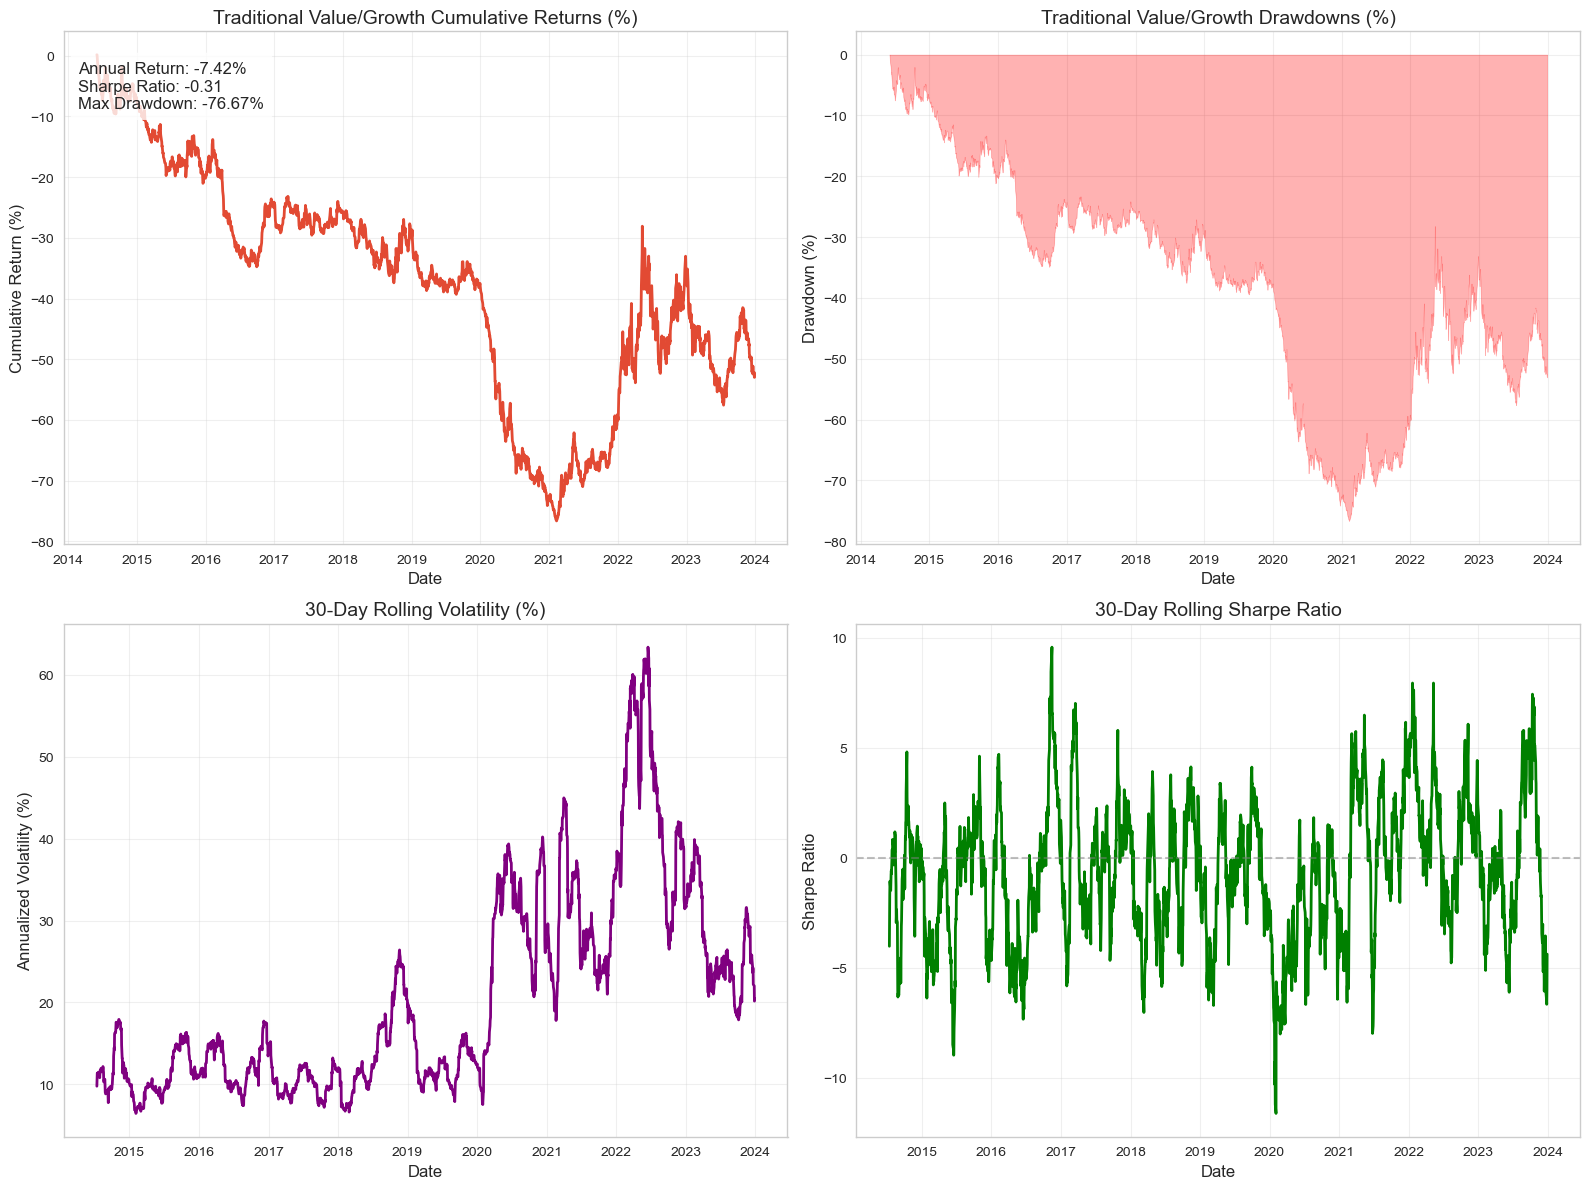

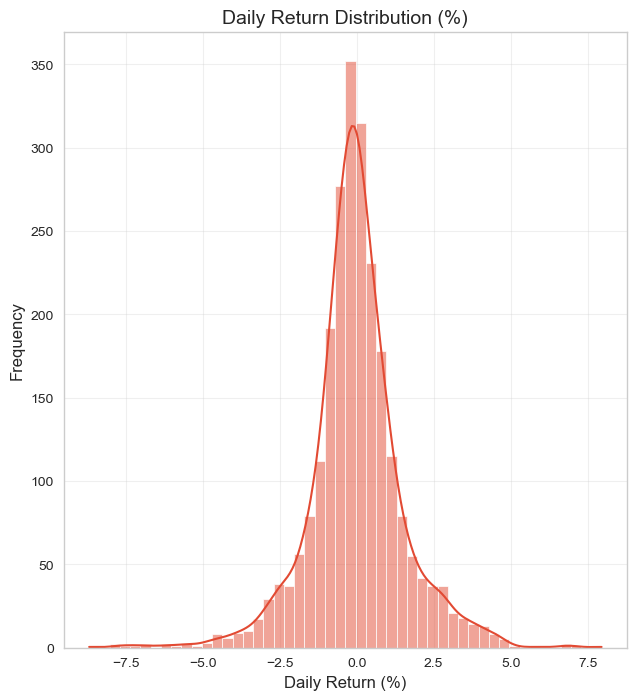

<Figure size 1600x800 with 0 Axes>

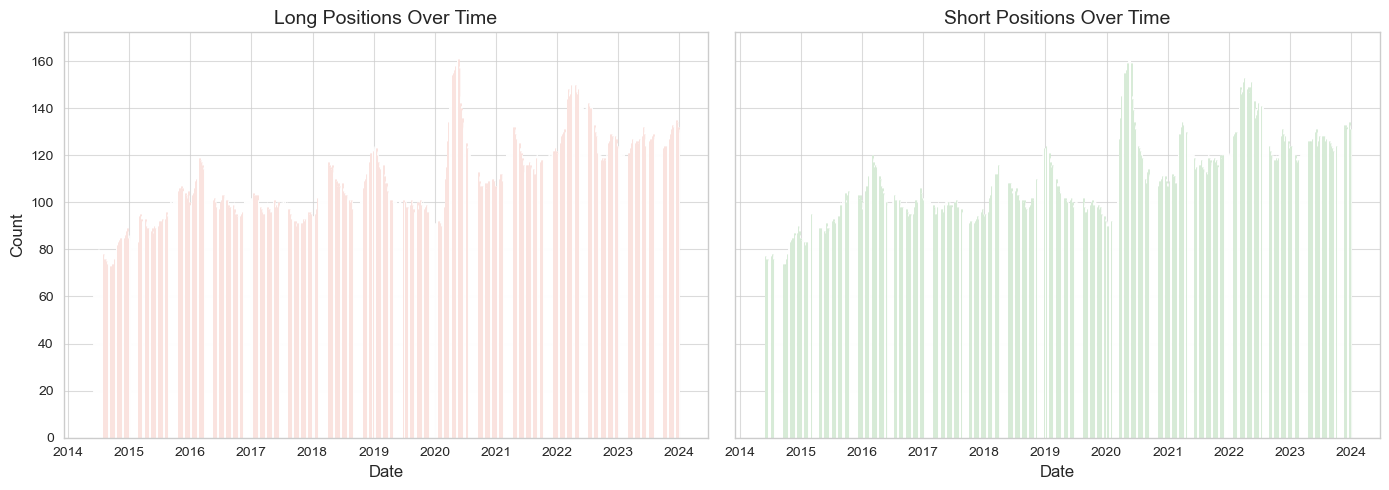

<Figure size 1000x800 with 0 Axes>

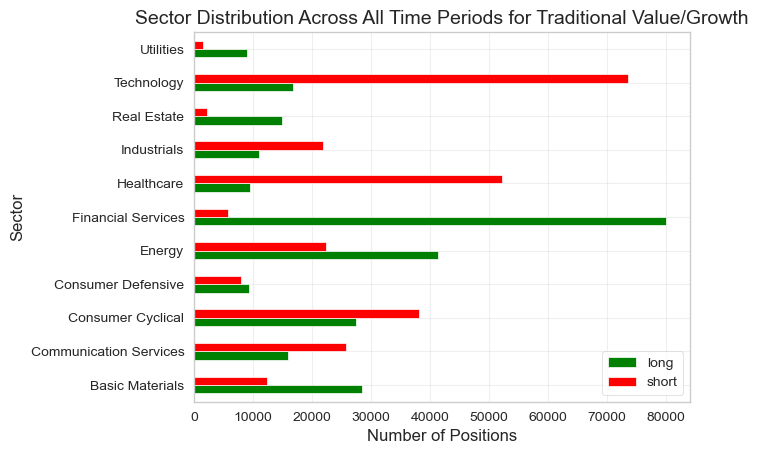

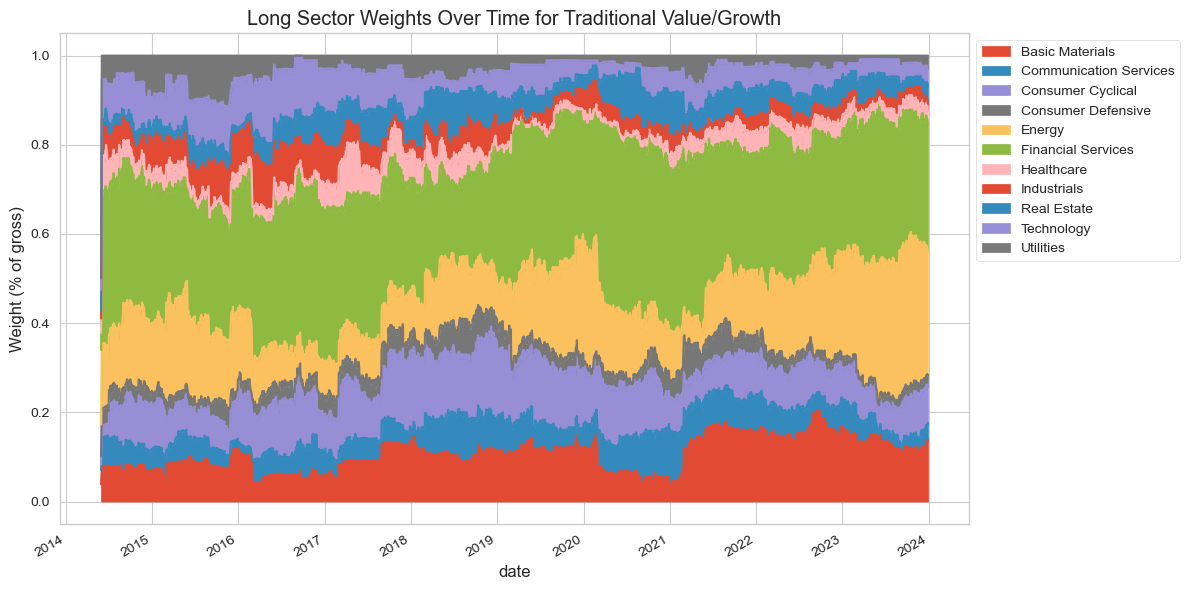

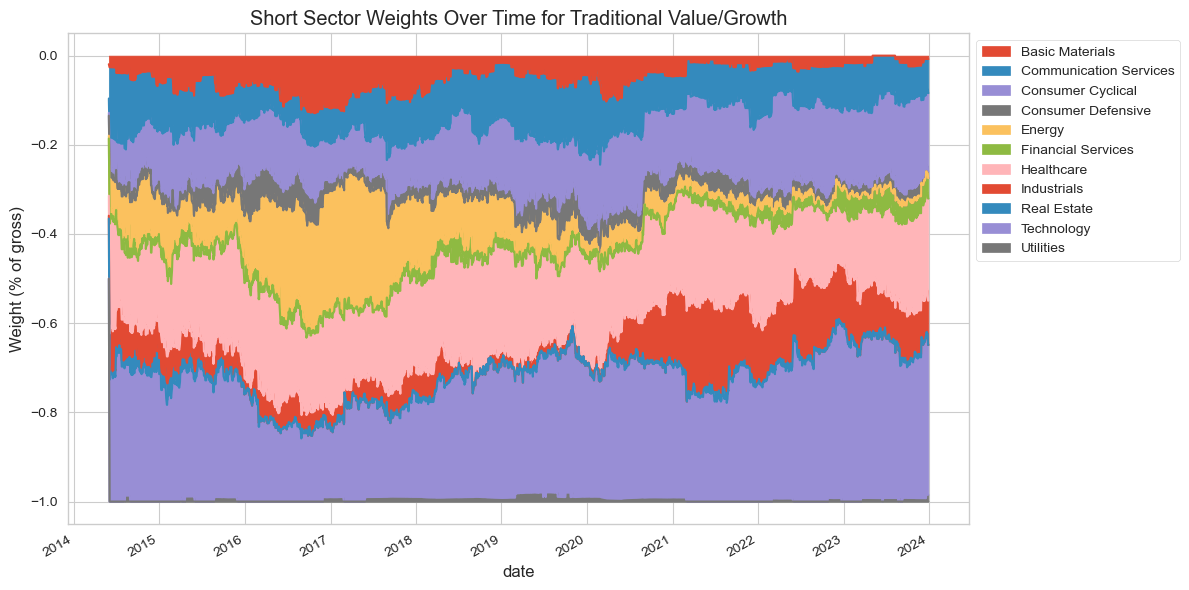

<Figure size 640x480 with 0 Axes>

In [205]:
print(f"Analyzing performance...")
metrics = analyze_performance(returns_trad_df)
strategy='traditional'

print(f"\nPerformance Summary - {strategy.capitalize()} Strategy:")
print(f"Total Return: {metrics['total_return']:.2%}")
print(f"Annualized Return: {metrics['annualized_return']:.2%}")
print(f"Annualized Volatility: {metrics['annualized_volatility']:.2%}")
print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
print(f"Maximum Drawdown: {metrics['max_drawdown']:.2%}")
print(f"Win Rate: {metrics['win_rate']:.2%}")


print(f"\nVisualizing results...")
visualize_performance(returns_trad_df, metrics, trades_trad_df, f"{strategy.capitalize()} Value/Growth")

Analyzing performance...

Performance Summary - Enhanced Strategy:
Total Return: 122.30%
Annualized Return: 8.70%
Annualized Volatility: 12.38%
Sharpe Ratio: 0.70
Maximum Drawdown: -20.81%
Win Rate: 53.46%

Visualizing results...


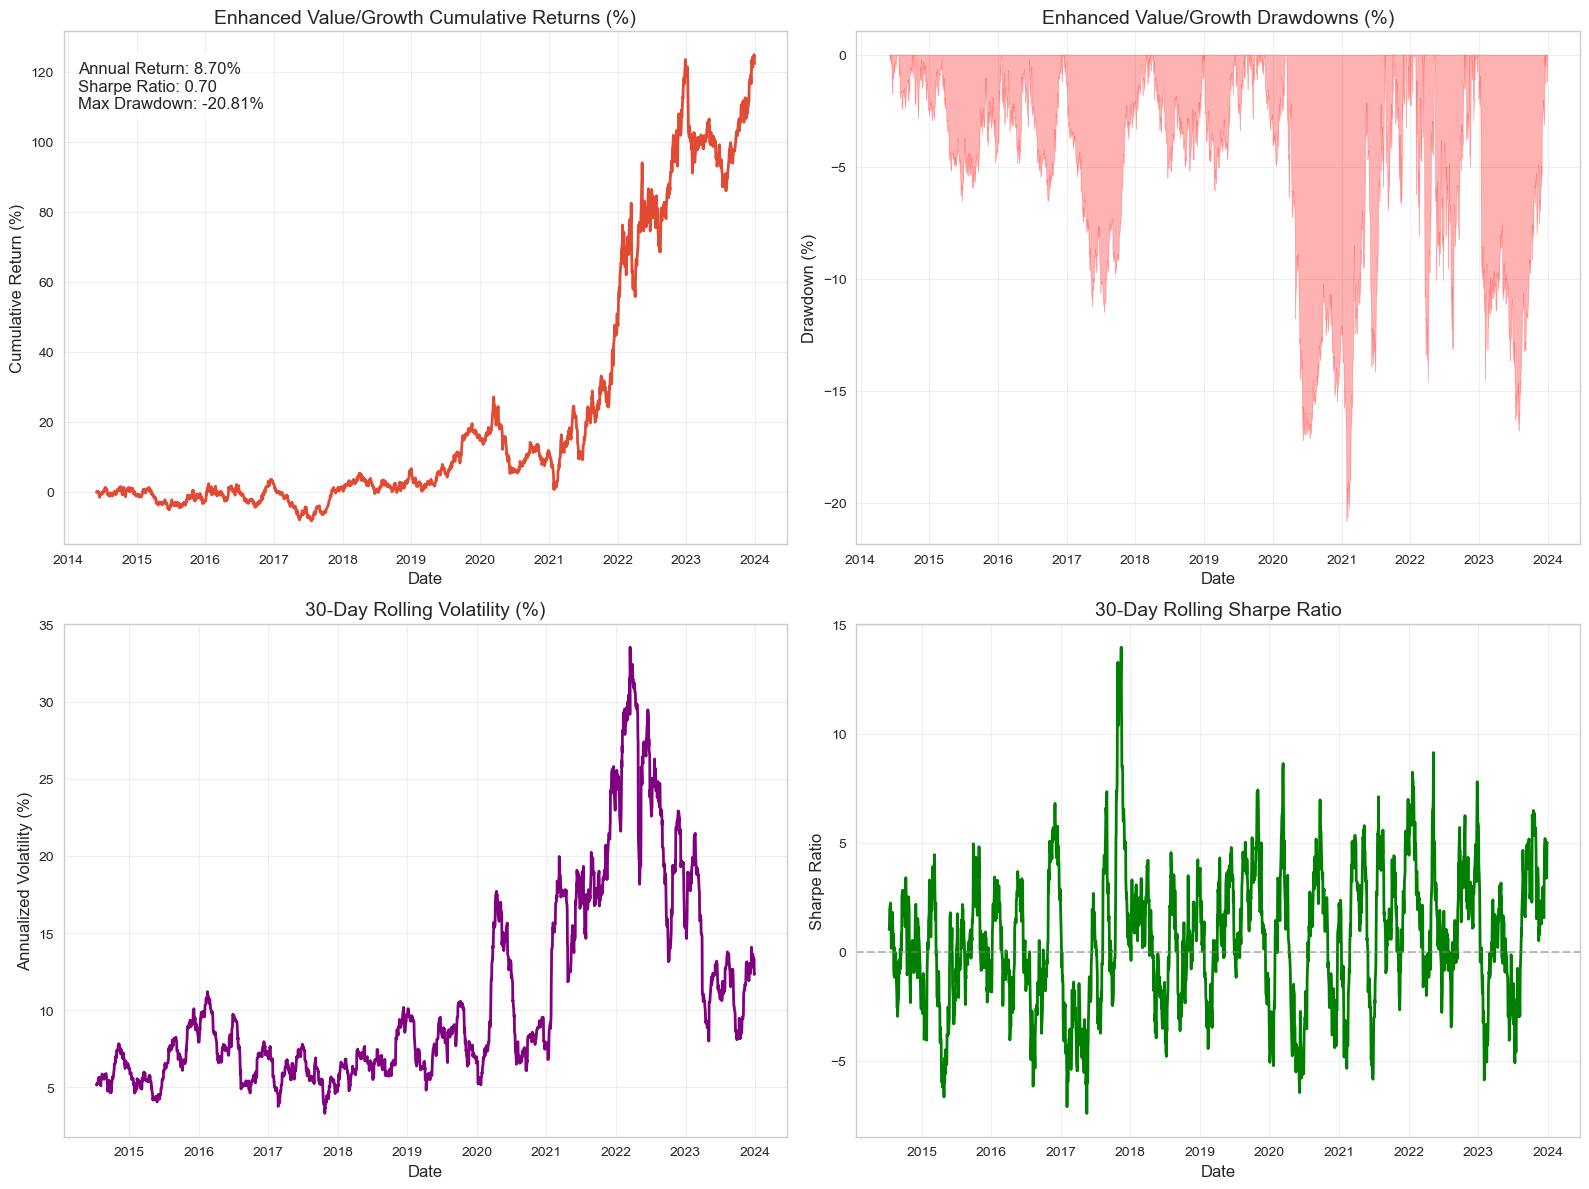

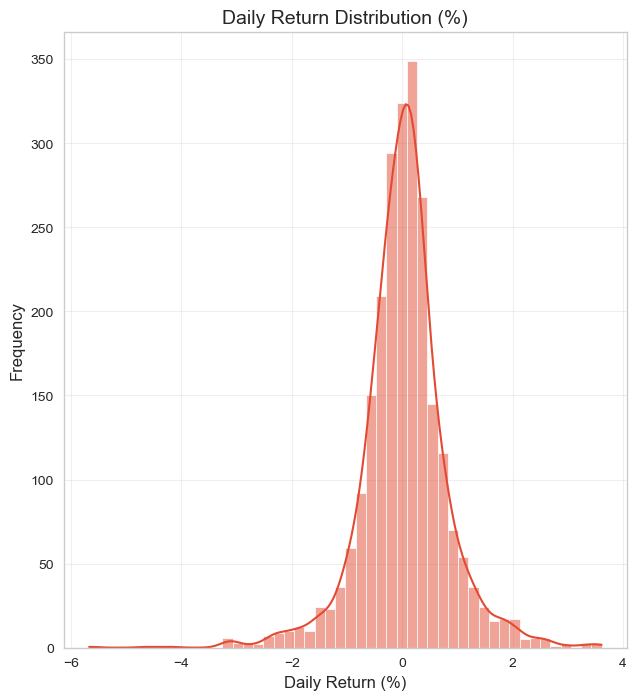

<Figure size 1600x800 with 0 Axes>

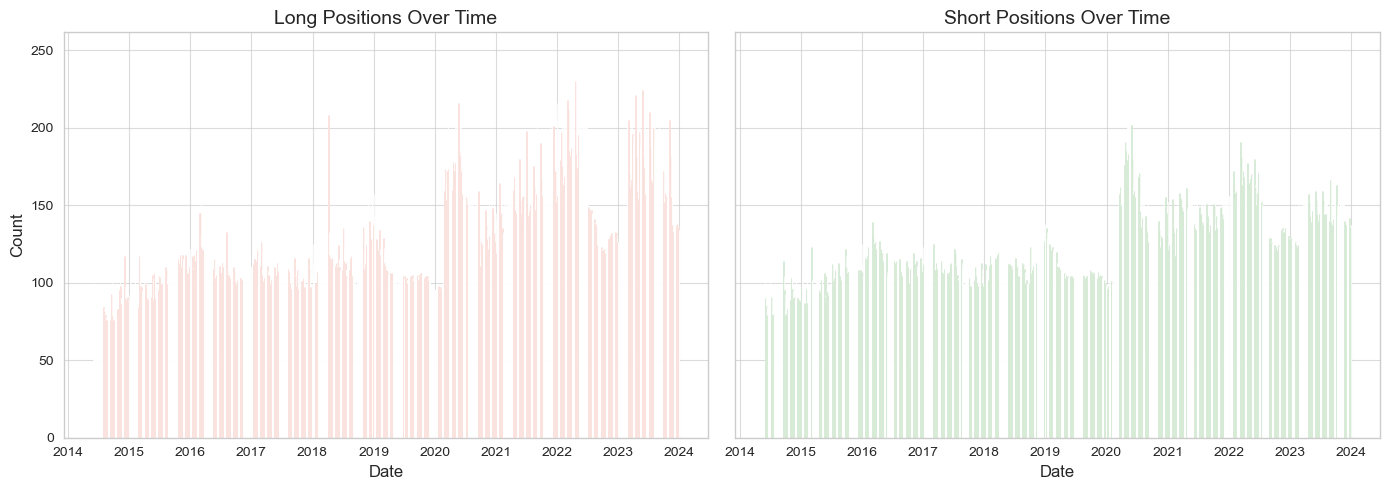

<Figure size 1000x800 with 0 Axes>

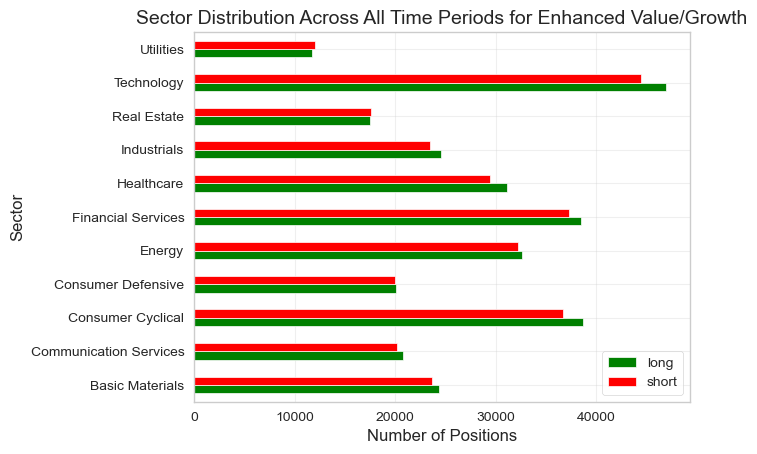

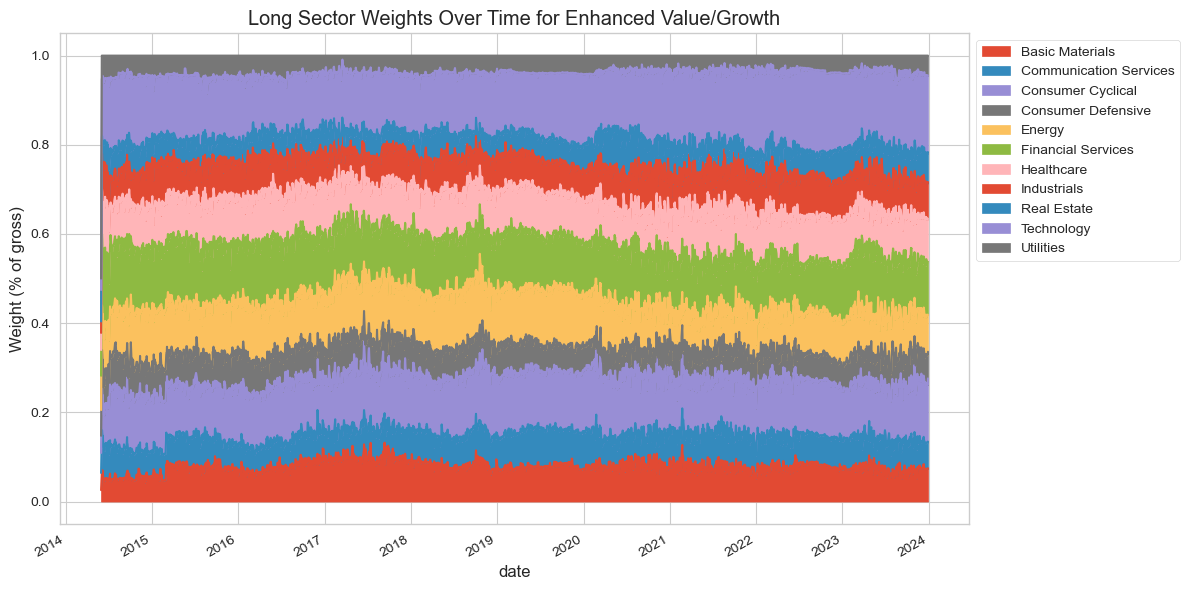

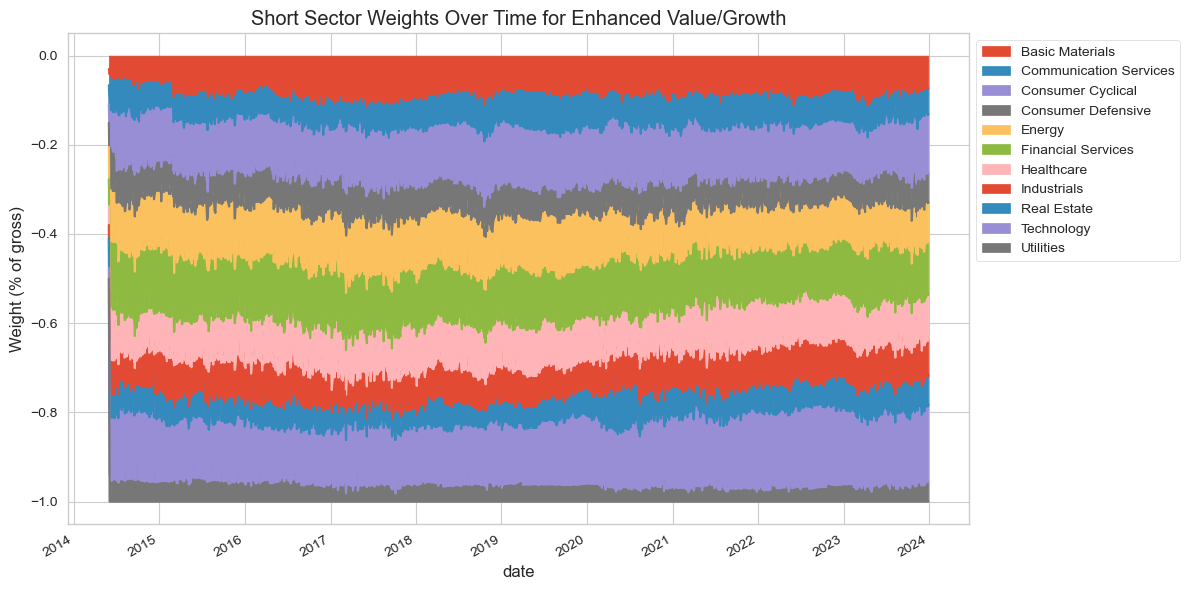

<Figure size 640x480 with 0 Axes>

In [206]:
print(f"Analyzing performance...")
metrics_enhanced = analyze_performance(returns_enhanced_df)
strategy='enhanced'

print(f"\nPerformance Summary - {strategy.capitalize()} Strategy:")
print(f"Total Return: {metrics_enhanced['total_return']:.2%}")
print(f"Annualized Return: {metrics_enhanced['annualized_return']:.2%}")
print(f"Annualized Volatility: {metrics_enhanced['annualized_volatility']:.2%}")
print(f"Sharpe Ratio: {metrics_enhanced['sharpe_ratio']:.2f}")
print(f"Maximum Drawdown: {metrics_enhanced['max_drawdown']:.2%}")
print(f"Win Rate: {metrics_enhanced['win_rate']:.2%}")


print(f"\nVisualizing results...")
visualize_performance(returns_enhanced_df, metrics_enhanced, trades_enhanced_df, f"{strategy.capitalize()} Value/Growth")